# Analysis of Free Kicks
### Introduction

This analysis looks into the effectiveness of free kick shots on goal and the relative effectiveness of different shot choices of these free kicks.

We conduct our analysis from the perspective of a right-footed free kick taker. With this perspective, there are essentially four possible shot types to consider. These shot types consist of the four possible combinations of shooting from either the left or the right of net, and shooting towards the far post or near post from these positions. The figure below summarizes these four shot types, along with the typical defensive wall and goalkeeper positioning for these situations.

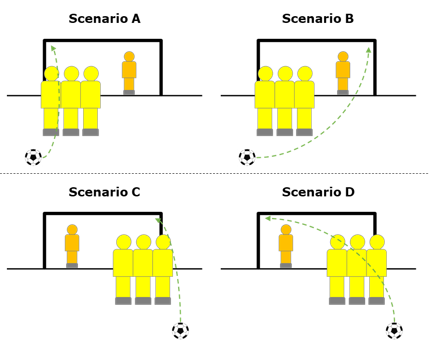


For the left footed case, these scenarios are essentially the same, just reflected left to right. Based on this we will "reflect" the left footed free kicks in our data to analyze them along with right footed free kicks on a consistent basis (i.e. reflected across the middle of the field). Lastly, we assume that all free kicks are struck on the inside of the foot with at least some minor right-to-left curve. This doesn't capture any outside the foot or knuckleball free kicks, however these make up a very small percentage of free kick attempts.

While not readily obvious, a team can essentially choose from any of the 4 scenarios at any free kick attempt, regardless of location, by choosing from either a right footed or left footed shooter.

### Data and approach

In scenarios A and C, the kick taker is trying to put their shot over or around the wall set up by the defensive team. Therefore, their shot has a significantly higher chance of being blocked, but will be challenging to save for the goalkeeper should it reach the net. Conversely, in scenarios B and D, the kick taker is aiming their shot to the keeper's side, which should have less chance of being blocked by the wall, but a greater chance of being saved by the goalkeeper.

In the data used for our analysis (see citation below), the target area of a free kick is only registered if the shot is not blocked. Therefore, any analysis considering only this information would ignore the high block rate for free kicks towards the near post (i.e. scenarios A and C) and as a result show an inflated scoring rate for these free kicks.

An examination of the data used identified that for free kicks blocked by the defending team, a "touch" event would be registered in the event data. Therefore, for each blocked free kick we identified the associated touch event and its x,y-position in order to determine where the free kick was blocked. Based on the trajectory implied by the free kick location and the block location, we then determined whether the free kick attempt was targeting the left or right side of the net. We first did this based on a linear approach. We then improved this approach using a cubic interpolating curve between the shot location and the net to account for the curve of a free kick.

Lastly, we estimate a scoring probability model for free kicks using a generalized additive model (GAM) using the logistic function. We then prepare visualizations of free kick scoring probability based on spatial location of the kick as well as shot choice. As above, these are all prepared from the perspective of a right-footed kick taker.

The data used for this analysis, as well as some data importing code, were accessed from:

* Pappalardo, Luca; Massucco, Emanuele (2019): Soccer match event dataset. figshare. Collection. https://doi.org/10.6084/m9.figshare.c.4415000

* Pappalardo, L., Cintia, P., Rossi, A. et al. A public data set of spatio-temporal match events in soccer competitions. Sci Data 6, 236 (2019) doi:10.1038/s41597-019-0247-7, https://www.nature.com/articles/s41597-019-0247-7

### Importing packages and importing data

In [1]:
import json
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Ellipse
import seaborn as sns
sns.set_theme()
from sklearn.model_selection import train_test_split
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

In [2]:
events={}
nations = ['Italy','England','Germany','France','Spain']
for nation in nations:
    with open('events/events_%s.json' %nation) as json_data:
        events[nation] = json.load(json_data)

matches={}
nations = ['Italy','England','Germany','France','Spain']
for nation in nations:
    with open('matches/matches_%s.json' %nation) as json_data:
        matches[nation] = json.load(json_data)

#### Identifying free kicks

Here we identify all free kick shot attempts from the data set, identified by the subeventId of 33.

In [3]:
sub_ids = [33]
FKs = []

for nation in nations:
    for ev in events[nation]:
        if ev['subEventId'] in sub_ids:
            tags = []            
            for i in range(len(ev['tags'])):
                tags.append(ev['tags'][i]['id'])
            FKs.append([ev['matchId'],ev['matchPeriod'],ev['eventSec'],ev['id'],ev['teamId'],nation,ev['subEventId'],
                                      tags,ev['positions'][0]['x'],100-ev['positions'][0]['y']])
        
        else:
            pass

df_fk = pd.DataFrame(FKs, columns=['matchId','matchPeriod','eventSec','id','teamId','nation','eventId','tags','x','y'])

print('Number of direct free kicks observed: {:.0f}'.format(len(df_fk)))

Number of direct free kicks observed: 2038


## Exploratory analysis and feature engineering

Firstly, we create some indicator variables from the tags information. We identify the location on the net the shots were aimed towards based on the group of goal location tags (only for non-blocked free kicks).

In [4]:
df_fk['right_foot'] = df_fk['tags'].apply(lambda x: x.count(402))
df_fk['goal'] = df_fk['tags'].apply(lambda x: x.count(101))

# Creating the list of goal locations from the Wyscout data.

goal_locs = [1201 + i for i in range(23)]
goal_locs.append(2101)

# Assigning the relevant goal location tag as the targeted goal location.

for i in range(len(df_fk)):
    df_fk.loc[i,'goal_loc'] = [j for j in df_fk['tags'][i] if j in goal_locs][0]

df_fk['goal_loc'] = df_fk['goal_loc'].astype('int32')

#### Identifying free kick blocks

As discussed, the data identifies a block of a free kick as a "touch" event. Here we identify all opposing team touches that immediately followed a free kick shot attempt. This is done using the subeventIds.

In [5]:
sub_ids = [72, 33]
blocks = []

for nation in nations:
    for index, ev in enumerate(events[nation]):
        if index == 0:
            pass
        elif ((ev['subEventId'] == sub_ids[0]) & (events[nation][index-1]['subEventId'] == sub_ids[1])):
            tags = []            
            for i in range(len(ev['tags'])):
                tags.append(ev['tags'][i]['id'])
            blocks.append([ev['matchId'],ev['matchPeriod'],ev['eventSec'],ev['id'],ev['teamId'],nation,ev['subEventId'],
                                      tags,ev['positions'][0]['x'],100-ev['positions'][0]['y']])
        else:
            pass

df_blocks = pd.DataFrame(blocks, columns=['matchId','matchPeriod','eventSec','id','teamId','nation','eventId','tags','x','y'])

print('Number of free kick blocks observed: {:.0f}'.format(len(df_blocks)))

Number of free kick blocks observed: 601


#### Identifying block locations

Here we add the "block location" for each of the blocked free kicks based on the location of the opposing team's touch that follows a free kick shot. We limit the time difference between the block and the shot to 3 seconds to ensure we exclude any touches that are not really a block to the associated free kick.

Because touches for each team are always relative to their own side of the field, we reflect the positions of the touches for the opposing team to accurately reflect the block position relative to the free kick location.

In [6]:
df_fk['block_x'] = np.nan
df_fk['block_y'] = np.nan

for i in range(len(df_fk)):
    if df_fk.loc[i,'goal_loc'] == 2101:
        block = df_blocks.loc[(df_blocks['matchId'] == df_fk.loc[i,'matchId']) & 
                                          (df_blocks['eventSec'] > df_fk.loc[i,'eventSec']) &
                                          (df_blocks['eventSec'] < df_fk.loc[i,'eventSec']+3)]
        if block.empty == True:
            pass        
        elif block.iloc[0,8] < 50:
            df_fk.loc[i,'block_x'] = 100-block.iloc[0,8]
            df_fk.loc[i,'block_y'] = 100-block.iloc[0,9]          
        else:
            df_fk.loc[i,'block_x'] = block.iloc[0,8]
            df_fk.loc[i,'block_y'] = block.iloc[0,9]
    else:
        pass

#### Filtering blocked free kicks

We now want to filter out some noise from our data by excluding blocked free kicks that clearly don't represent a reasonable shot attempt.

Several filters are applied below with explanations for the logic/approach in each case.

In [7]:
# We first create a new DF by excluding any blocked free kicks for which we do not have the block location.

df_fk_new = df_fk.loc[~((df_fk['goal_loc'] == 2101) & ((df_fk['block_x'].isna() == True) | (df_fk['block_y'].isna() == True)))]

# We limit to free kicks that are within a reasonable scoring position by limiting the x and y ranges.

df_fk_new = df_fk_new.loc[(df_fk['x'] > 65) & (df_fk['x'] < 83.4) & ((df_fk['y'] > 15) & (df_fk['y'] < 85))]

# We remove free kicks that are blocked outside of a reasonable area to remove any unusual free kicks.

df_fk_new = df_fk_new.loc[(df_fk['goal_loc'] != 2101) | (((df_fk['block_x'] > 65) & (df_fk['block_x'] < 100)) & ((df_fk['block_y'] > 20) & (df_fk['block_y'] < 80)))]

# We remove any blocked free kicks that were kicked in the opposite direction of the opposition net.

df_fk_new = df_fk_new.loc[(df_fk['goal_loc'] != 2101) | (df_fk['block_x'] > df_fk['x'])]

# We remove anything that is blocked very close to the origin of the free kick as this is likely not a block.

df_fk_new = df_fk_new.loc[(df_fk['goal_loc'] != 2101) | (((((df_fk_new['x']-df_fk_new['block_x'])*(104/100))**2+((df_fk_new['y']-df_fk_new['block_y'])*(68/100))**2)**0.5) > 5)]

# Lastly, we take out really bad misses/potentially misclassed free kicks. This is done by removing any blocked free kick whose linear trajectory is outside of the 18 yard box,
# (i.e. is very wide of the net or going to the sidelines).

df_fk_new = df_fk_new.loc[(df_fk['goal_loc'] != 2101) |
                          (((df_fk_new['y']+((df_fk_new['block_y']-df_fk_new['y'])/(df_fk_new['block_x']-df_fk_new['x']))*(100-df_fk_new['x'])) < 80) &
                          ((df_fk_new['y']+((df_fk_new['block_y']-df_fk_new['y'])/(df_fk_new['block_x']-df_fk_new['x']))*(100-df_fk_new['x'])) > 20))]

# To finish, we reset the index now that we have filtered down our data.

df_fk_new = df_fk_new.reset_index().drop(['index'],axis=1)

#### Visualizing blocked free kicks

Now that we have filtered down our data, let's do some preliminary visualization of these blocked free kicks to confirm we are on the right track.

Below is a modified version of the plotting function from Pappalardo et al. (2019) which will be used the visualize the data.

In [8]:
def pitch(ax, color='black', grass=False, axis=True, arrow=True):

    #Pitch Outline & Centre Line
    ax.plot([0,0],[0,100], color=color)
    ax.plot([0,100],[100,100], color=color)
    ax.plot([100,100],[100,0], color=color)
    ax.plot([100,0],[0,0], color=color)
    ax.plot([50,50],[0,100], color=color)

    #Left Penalty Area
    ax.plot([16.5,16.5],[80,20],color=color)
    ax.plot([0,16.5],[80,80],color=color)
    ax.plot([16.5,0],[20,20],color=color)

    #Right Penalty Area
    ax.plot([83.5,100],[80,80],color=color)
    ax.plot([83.5,83.5],[80,20],color=color)
    ax.plot([83.5,100],[20,20],color=color)

    #Left 6-yard Box
    ax.plot([0,5.5],[65,65],color=color)
    ax.plot([5.5,5.5],[65,35],color=color)
    ax.plot([5.5,0.5],[35,35],color=color)

    #Right 6-yard Box
    ax.plot([100,94.5],[65,65],color=color)
    ax.plot([94.5,94.5],[65,35],color=color)
    ax.plot([94.5,100],[35,35],color=color)

    #Prepare Circles
    centreCircle = Ellipse((50, 50), width=30, height=39, edgecolor=color, facecolor="None", lw=1.8)
    centreSpot = Ellipse((50, 50), width=1, height=1.5, edgecolor=color, facecolor=color, lw=1.8)
    leftPenSpot = Ellipse((11, 50), width=1, height=1.5, edgecolor=color, facecolor=color, lw=1.8)
    rightPenSpot = Ellipse((89, 50), width=1, height=1.5, edgecolor=color, facecolor=color, lw=1.8)

    #Draw Circles
    ax.add_patch(centreCircle)
    ax.add_patch(centreSpot)
    ax.add_patch(leftPenSpot)
    ax.add_patch(rightPenSpot)
    
    #limit axis
    #ax.set_xlim(0,100)
    #ax.set_ylim(0,100)
    
    img = plt.imread("pitch.png")
    
    #Add grass background
    if grass == True:
        ax.imshow(img, aspect='auto', extent =[0,100,0,100])
    
    #Turn off axis
    if axis == False:
        ax.axis('off')
    
    #Add attacking arrow indication
    if arrow == True:
        ax.annotate("", xy=(25, 5), xytext=(5, 5),
                    arrowprops=dict(arrowstyle="->", linewidth=1, color='black'))
        
    return fig,ax

We plot a random sample of the identified blocked free kicks below. Generally the patterns of the blocked free kicks look reasonable.

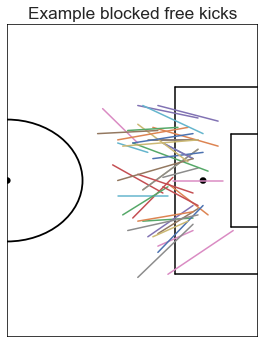

In [9]:
block_fk = df_fk_new.loc[df_fk_new['block_x'].isna() == False]
block_fk = block_fk.reset_index().drop(['index'],axis=1)

fig, ax = plt.subplots(figsize=(4.5,5.75))
pitch(ax,'black', grass=False, axis=False, arrow=False)

random_indices = np.random.randint(0,len(block_fk),size=40)

for i in random_indices:
    plt.plot([block_fk.loc[i,'x'],block_fk.loc[i,'block_x']],[block_fk.loc[i,'y'],block_fk.loc[i,'block_y']])

ax.set_xlim(50,100)
ax.set_ylim(0,100)
ax.set_title("Example blocked free kicks", fontsize="x-large")
plt.show()

#### Classifying blocked free kicks

We now look to classify these blocked free kicks into either shots to the left or right of the goal.

The first step of this analysis is to "reflect" left footed kicks to be in the same pattern as right footed kicks. This is done by reflecting the y-coordinates of the shot location and block location.

In [10]:
df_fk_new.loc[df_fk_new['right_foot']==0,'y'] *= -1
df_fk_new.loc[df_fk_new['right_foot']==0,'y'] += 100
df_fk_new.loc[df_fk_new['right_foot']==0,'block_y'] *= -1
df_fk_new.loc[df_fk_new['right_foot']==0,'block_y'] += 100

Our first approach to classifying these blocked free kicks is by drawing a straight line between the shot location and the middle of the net. If the shot is blocked above this line, it will be classified as targeting the "left" side of the net, and vice versa if it is below. We present a diagram below demonstrating this approach.

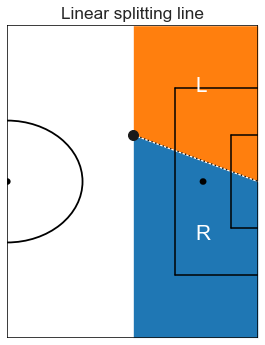

In [11]:
fig, ax = plt.subplots(figsize=(4.5,5.75))
pitch(ax,'black', grass=False, axis=False, arrow=False)

plt.scatter(75,65, s=100, c='k', zorder=10)
plt.plot([75,100],[65,50], ls=':', c='k', zorder=9)

ax.fill_between([75,100], [100,100], [65,50], facecolor='tab:orange', interpolate=True)
ax.fill_between([75,100], [0,0], [65,50], facecolor='tab:blue', interpolate=True)

ax.annotate("L", xy=((75+100)/2, 50+(65+50)/4), fontsize='xx-large', color = 'w', zorder=15)
ax.annotate("R", xy=((75+100)/2, 60-(65+50)/4), fontsize='xx-large', color = 'w', zorder=15)

ax.set_xlim(50,100)
ax.set_ylim(0,100)
ax.set_title("Linear splitting line", fontsize='x-large')
plt.show()

Below we classify the blocked free kicks on this basis.

In [12]:
df_fk_new['side'] = np.nan
left_side = [1204,1205,1208,1211,1212,1215,1218,1219,1222]
right_side = [1202,1206,1209,1210,1213,1216,1217,1220,1223]
center = [1201,1203,1207,1214,1221]

for i in range(len(df_fk_new)):
    if df_fk_new.loc[i,'goal_loc'] == 2101:
        if df_fk_new.loc[i,'block_y'] > df_fk_new.loc[i,'y']-(df_fk_new.loc[i,'block_x']-df_fk_new.loc[i,'x'])*((df_fk_new.loc[i,'y']-50)/(100-df_fk_new.loc[i,'x'])):
            df_fk_new.loc[i,'side'] = 'left'
        elif df_fk_new.loc[i,'block_y'] < df_fk_new.loc[i,'y']-(df_fk_new.loc[i,'block_x']-df_fk_new.loc[i,'x'])*((df_fk_new.loc[i,'y']-50)/(100-df_fk_new.loc[i,'x'])):
            df_fk_new.loc[i,'side'] = 'right'
        else:
            pass
    elif df_fk_new.loc[i,'right_foot'] == 1:
        if df_fk_new.loc[i,'goal_loc'] in left_side:
            df_fk_new.loc[i,'side'] = 'left'
        elif df_fk_new.loc[i,'goal_loc'] in right_side:
            df_fk_new.loc[i,'side'] = 'right'
        elif df_fk_new.loc[i,'goal_loc'] in center:
            df_fk_new.loc[i,'side'] = 'center'
    elif df_fk_new.loc[i,'right_foot'] == 0:
        if df_fk_new.loc[i,'goal_loc'] in left_side:
            df_fk_new.loc[i,'side'] = 'right'
        elif df_fk_new.loc[i,'goal_loc'] in right_side:
            df_fk_new.loc[i,'side'] = 'left'
        elif df_fk_new.loc[i,'goal_loc'] in center:
            df_fk_new.loc[i,'side'] = 'center'
    else:
        pass

Now that we have classified the target location of the blocked free kicks, we can analyze the success rates of each of the four shot types discussed earlier in this notebook.

In [13]:
a = df_fk_new.loc[((df_fk_new['side']=='left') & (df_fk_new['y']>50))]
b = df_fk_new.loc[((df_fk_new['side']=='right') & (df_fk_new['y']>50))]
c = df_fk_new.loc[((df_fk_new['side']=='right') & (df_fk_new['y']<50))]
d = df_fk_new.loc[((df_fk_new['side']=='left') & (df_fk_new['y']<50))]

print(
'\033[1m'+' Goal Scoring Rates (Attempts)'+'\033[0m','\n',
'Scenario A (near post from the left side): {:.2%} (count: {})'.format(a['goal'].mean(),a['goal'].count()),'\n',
'Scenario B (far post from the left side): {:.2%} (count: {})'.format(b['goal'].mean(),b['goal'].count()),'\n',
'Scenario C (near post from the right side): {:.2%} (count: {})'.format(c['goal'].mean(),c['goal'].count()),'\n',
'Scenario D (far post from the right side): {:.2%} (count: {})'.format(d['goal'].mean(),d['goal'].count()),'\n')

 Goal Scoring Rates (Attempts) 
 Scenario A (near post from the left side): 7.62% (count: 709) 
 Scenario B (far post from the left side): 7.81% (count: 269) 
 Scenario C (near post from the right side): 7.35% (count: 272) 
 Scenario D (far post from the right side): 6.77% (count: 133) 



As shown above, a right footed shooter has a higher success rate shooting from the left side. Interestingly, the far post shot has a slightly higher success rate in our data, but is only utilized about a third as often. Unsurprisingly the far post attempt from the right side is the weakest of the four, as the trajectory/curve of the ball in this scenario favors the goalkeeper.

We next want to look a bit further into our classification of the blocked free kicks. The linear approach we have taken is not ideal because a free kick will almost always be struck with some degree of curvature. Based on the assumption that the curvature for right foot kickers is predominately right-to-left, this would result in too many blocks being assigned to scenarios B and C, thus lowering their goal rates.

In order to validate this theory, we analyze the block rates of each of the shot scenarios. We expect that, if the free kick blocks were properly assigned, we would see a higher block rate for free kicks targeted towards the near post (i.e. where the defensive wall is). These numbers are presented below.

In [14]:
print(
'\033[1m'+' Block Rates'+'\033[0m','\n',
'Scenario A (near post from the left side): {:.1%} '.format((a.loc[a['goal_loc']==2101].count()/a.count())[0]),'\n',
'Scenario B (far post from the left side): {:.1%} '.format((b.loc[b['goal_loc']==2101].count()/b.count())[0]),'\n',
'Scenario C (near post from the right side): {:.1%} '.format((c.loc[c['goal_loc']==2101].count()/c.count())[0]),'\n',
'Scenario D (far post from the right side): {:.1%} '.format((d.loc[d['goal_loc']==2101].count()/d.count())[0]))

 Block Rates 
 Scenario A (near post from the left side): 32.0%  
 Scenario B (far post from the left side): 39.8%  
 Scenario C (near post from the right side): 26.5%  
 Scenario D (far post from the right side): 32.3% 


As shown above, scenario B has a higher block rate than scenario A, despite the former not targetting the defensive wall. This pattern similarly holds true between scenarios C and D.

By adding a right-to-left curvature to our process handling the blocked free kicks, we will move more blocks from scenario B to scenario A. However we will also be moving more blocks from scenario C to scenario D. In order to ensure we are not overly influencing our results, we implement a very gentle curvature to the process using a cubic interpolation spline between the free kick location and the middle of the net. The function for the splines is defined below. We define the curvature by adding a fixed angle to the direct line to the goal, and adding an equivalent angle at the goal as well. The default we use adds 10 degrees to the angle (pi/18 radians), which results in a very slight curvature.

We also present a plot demonstrating some example splitting splines below. As discussed previously, we are considering from the perspective of a right footed kicker, and assume that all these free kicks have a right-to-left curve.

In [15]:
def fk_spline(x1,y1,x,curve=np.pi/18):
    if y1 > 50:
        t_x = (x-x1)/(100-x1)
        slope = ((50-y1)/(100-x1))
        a = np.tan(np.arctan(slope)-curve)*(100-x1)-(50-y1)
        b = -np.tan(np.pi/2-(np.pi/2-np.arctan(slope)-curve))*(100-x1)+(50-y1)
        
        return (1-t_x)*y1+t_x*50+(t_x*(1-t_x))*((1-t_x)*a+t_x*b)
    
    elif y1 <= 50:
        t_x = (x-x1)/(100-x1)
        slope = ((50-y1)/(100-x1))
        a = np.tan(np.arctan(slope)-curve)*(100-x1)-(50-y1)
        b = -np.tan(np.pi/2-(np.pi/2-np.arctan(slope)-curve))*(100-x1)+(50-y1)

        return (1-t_x)*y1+t_x*50+(t_x*(1-t_x))*((1-t_x)*a+t_x*b)

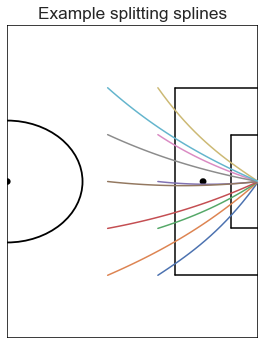

In [16]:
fig, ax = plt.subplots(figsize=(4.5,5.75))
pitch(ax,'black', axis=False, arrow=False)

x = np.linspace(80,100,20)
y = np.linspace(20,80,5)
x_2 = np.linspace(70,100,30)

for i in range(len(y)):
    plt.plot(x,fk_spline(80,y[i],x))
    plt.plot(x_2,fk_spline(70,y[i],x_2))

ax.set_xlim(50,100)
ax.set_ylim(0,100)
ax.set_title("Example splitting splines", fontsize="x-large")
plt.show()

To clarify, these are the decision borders between the assigning a free kick as being targeted to the left or right from a given free kick location. As we are dealing with only right footed free kicks (or reflected left footed kicks), the curvature is assumed to always be right-to-left.

An updated visual demonstration of this decision process is presented below.

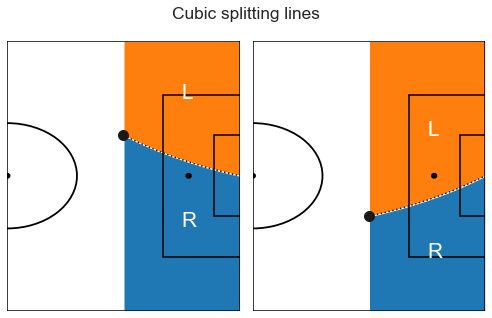

In [17]:
fig, ax = plt.subplots(1,2,figsize=(7,4.5))
pitch(ax[0],'black', grass=False, axis=False, arrow=False)
pitch(ax[1],'black', grass=False, axis=False, arrow=False)

x = np.linspace(75,100,25)
y = fk_spline(75,65,x)
y_2 = fk_spline(75,35,x)

ax[0].scatter(75,65, s=100, c='k', zorder=10)
ax[0].plot(x,y, ls=':', c='k', zorder=9)

ax[0].fill_between(x, 100, y, facecolor='tab:orange', interpolate=True)
ax[0].fill_between(x, 0, y, facecolor='tab:blue', interpolate=True)

ax[0].annotate("L", xy=((75+100)/2, 50+(65+50)/4), fontsize='xx-large', color = 'w', zorder=15)
ax[0].annotate("R", xy=((75+100)/2, 60-(65+50)/4), fontsize='xx-large', color = 'w', zorder=15)

ax[1].scatter(75,35, s=100, c='k', zorder=10)
ax[1].plot(x,y_2, ls=':', c='k', zorder=9)

ax[1].fill_between(x, 100, y_2, facecolor='tab:orange', interpolate=True)
ax[1].fill_between(x, 0, y_2, facecolor='tab:blue', interpolate=True)

ax[1].annotate("L", xy=((75+100)/2, 65), fontsize='xx-large', color = 'w', zorder=15)
ax[1].annotate("R", xy=((75+100)/2, 20), fontsize='xx-large', color = 'w', zorder=15)

ax[0].set_xlim(50,100)
ax[0].set_ylim(0,100)

ax[1].set_xlim(50,100)
ax[1].set_ylim(0,100)

fig.suptitle("Cubic splitting lines", fontsize='x-large')

plt.tight_layout()
plt.show()

***Note:*** In future updates I intend to modify this structure by splitting the net into thirds. The process will then produce two splines connecting to the points between the left and middle thirds, and the right and middle thirds. We will then discard free kicks that fall into the middle region of the splines. This will remove any potentially ambiguous free kicks.

We now assign each blocked free kick an "adjusted side" using this new decision process.

In [18]:
df_fk_new['adjusted_side'] = np.nan
left_side = [1204,1205,1208,1211,1212,1215,1218,1219,1222]
right_side = [1202,1206,1209,1210,1213,1216,1217,1220,1223]
center = [1201,1203,1207,1214,1221]

for i in range(len(df_fk_new)):
    if df_fk_new.loc[i,'goal_loc'] == 2101:
        if df_fk_new.loc[i,'block_y'] > fk_spline(df_fk_new.loc[i,'x'],df_fk_new.loc[i,'y'],df_fk_new.loc[i,'block_x']):
            df_fk_new.loc[i,'adjusted_side'] = 'left'
        elif df_fk_new.loc[i,'block_y'] < fk_spline(df_fk_new.loc[i,'x'],df_fk_new.loc[i,'y'],df_fk_new.loc[i,'block_x']):
            df_fk_new.loc[i,'adjusted_side'] = 'right'
        else:
            pass
    elif df_fk_new.loc[i,'right_foot'] == 1:
        if df_fk_new.loc[i,'goal_loc'] in left_side:
            df_fk_new.loc[i,'adjusted_side'] = 'left'
        elif df_fk_new.loc[i,'goal_loc'] in right_side:
            df_fk_new.loc[i,'adjusted_side'] = 'right'
        elif df_fk_new.loc[i,'goal_loc'] in center:
            df_fk_new.loc[i,'adjusted_side'] = 'center'
    elif df_fk_new.loc[i,'right_foot'] == 0:
        if df_fk_new.loc[i,'goal_loc'] in left_side:
            df_fk_new.loc[i,'adjusted_side'] = 'right'
        elif df_fk_new.loc[i,'goal_loc'] in right_side:
            df_fk_new.loc[i,'adjusted_side'] = 'left'
        elif df_fk_new.loc[i,'goal_loc'] in center:
            df_fk_new.loc[i,'adjusted_side'] = 'center'
    else:
        pass    

We present the same results as above using the adjusted side information identified above.

In [19]:
a = df_fk_new.loc[((df_fk_new['adjusted_side']=='left') & (df_fk_new['y']>50))]
b = df_fk_new.loc[((df_fk_new['adjusted_side']=='right') & (df_fk_new['y']>50))]
c = df_fk_new.loc[((df_fk_new['adjusted_side']=='right') & (df_fk_new['y']<50))]
d = df_fk_new.loc[((df_fk_new['adjusted_side']=='left') & (df_fk_new['y']<50))]

print(
'\033[1m'+' Goal Scoring Rates (Attempts)'+'\033[0m','\n',
'Scenario A (near post from the left side): {:.2%} (count: {})'.format(a['goal'].mean(),a['goal'].count()),'\n',
'Scenario B (far post from the left side): {:.2%} (count: {})'.format(b['goal'].mean(),b['goal'].count()),'\n',
'Scenario C (near post from the right side): {:.2%} (count: {})'.format(c['goal'].mean(),c['goal'].count()),'\n',
'Scenario D (far post from the right side): {:.2%} (count: {})'.format(d['goal'].mean(),d['goal'].count()))

 Goal Scoring Rates (Attempts) 
 Scenario A (near post from the left side): 7.29% (count: 741) 
 Scenario B (far post from the left side): 8.82% (count: 238) 
 Scenario C (near post from the right side): 7.63% (count: 262) 
 Scenario D (far post from the right side): 6.29% (count: 143)


After updating the blocked free kicks, we now see a significantly higher scoring rate for far post targeted free kicks from the left side versus the equivalent near post (i.e. scenario B vs A). This is a surprising result, given that these free kicks are selected only about a quarter of the time from left side positions.

Lastly, we see that scenario C has a slightly higher success rate while scenario D is clearly the worst and least utilized option.

## Modelling

We now do some modelling on the prepared data above. We will use a GAM framework using the logistic function to represent probability of scoring from a given free kick shot attempt.

The first step below will be to create two new variables for the model, being the distance from goal and angle from the center of goal. Both these features are calculated from the location of the free kick attempt. The distance variable requires converting the 100x100 coordinates back into actual field dimensions to get an accurate distance.

In [20]:
df_fk_new['dist'] = (((df_fk_new['x']-100)*(104/100))**2+((df_fk_new['y']-50)*(68/100))**2)**0.5

df_fk_new['angle'] = np.arctan((df_fk_new['y']-50)/(100-df_fk_new['x']))

#### Creating training data

As part of addressing the unbalanced nature of the dataset (i.e. significantly more unscored free kicks), we oversample successful free kicks in order to get an equally proportioned set of successful and failed free kick attempts.

The code below splits off a testing set consisting of 10% of the data. For the training data, we then take the number of failed free kicks in the sample and ovesample the successful free kicks with replacement until we have an equally proportioned set.

In [21]:
X = df_fk_new[['x','y','dist','angle','goal']]
seed = 1

# Split the data into training and testing groups to ensure no cross-over in the subsequent steps.

train, test = train_test_split(X, test_size=0.1, random_state=seed)

# Here we separate the successful and unsuccessful free kick attempts, and then oversample from the successful free kicks
# until we have equally sized sets.

train_fail = train.loc[train['goal']==0]
train_success = train.loc[train['goal']==1].sample(len(train_fail), replace=True, random_state=seed)

# Combine the subsamples, shuffle the combined data, reset the index and prepare the final training and test data.

train = pd.concat([train_success,train_fail], axis=0)
train = train.sample(frac=1, random_state=seed)

X_train = train.drop(['goal'],axis=1)
y_train = train['goal']

X_test = test.drop(['goal'],axis=1)
y_test = test['goal']

#### Fitting model

Here we set-up and fit the model using the training data. The model is relatively simple with tensor smoothing splines for the x,y-coordinates of the free kick attempt location. Next we include smoothing spline terms for the distance and angle to goal. The smoothing penalties are relatively strong and were determined based on some testing (i.e. gridsearch). For the tensor term, we have a strong smoothing penalty for the y-axis as it is more compressed than the x-axis when converted into the 100x100 coordinate system (i.e. because a soccer field is longer than it is wide).

In future updates to this model, we plan to incorporate some other contextual data such as the free kick ability of the free kick taker (e.g. from FIFA ratings), the ability of the goalkeeper, and other factors that may influence free kick success.

In [22]:
from pygam import LogisticGAM, te, s, f, l

gam = LogisticGAM(te(0,1, n_splines=10, lam=[50,75])+
                  s(2, lam=50)+
                  s(3, lam=50))

gam = gam.fit(X_train, y_train)

gam.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     12.0709
Link Function:                        LogitLink Log Likelihood:                                 -1776.5652
Number of Samples:                         2782 AIC:                                             3577.2721
                                                AICc:                                            3577.4049
                                                UBRE:                                               3.2893
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0787
Feature Function                  Lam

#### Model assessment

Below we assess the performance of the model on the test data. As expected, the model performs poorly on predicting successful free kicks as they are rare.

However, the log loss of our model is relatively strong, indicating that our probability predictions are reasonably strong, which is the main purpose of our analysis.

In [23]:
preds = gam.predict(X=X_test)
prob_preds = gam.predict_mu(X=X_test)

print(' Log loss: {:.2f}'.format(metrics.log_loss(y_test,prob_preds)),'\n\n',
      'Classification report:\n', metrics.classification_report(y_test,preds))

 Log loss: 0.65 

 Classification report:
               precision    recall  f1-score   support

           0       0.96      0.61      0.75       158
           1       0.08      0.56      0.13         9

    accuracy                           0.61       167
   macro avg       0.52      0.58      0.44       167
weighted avg       0.91      0.61      0.72       167



## Visualization

Below we assess free kick scoring probability across the attacking half of the field based on our model.

As described earlier in this notebook, this analysis is from the perspective of a right-footed kicker. For a left-footed kicker, a reflected version of the plots below would be appropriate.

As expected, the model predicts a greater chance of success the closer to the center and to the net the free kick attempt is. We see slightly more probability of success to the left of the net, which is consistent with our results above.

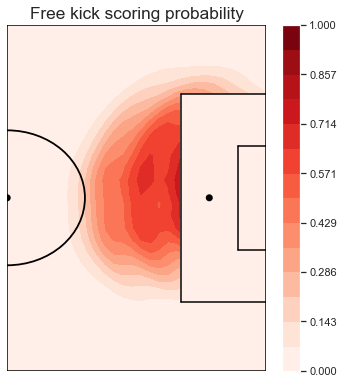

In [24]:
X0, X1 = np.mgrid[50:100:30j,0:100:30j]
X0_base, X1_base = np.mgrid[83.4:100:30j,20:80:30j]
Z_base = np.zeros((30,30))

X2 = ((((X0-100)*(104/100))**2+((X1-50)*(68/100))**2)**0.5)
X3 = np.arctan((X1-50)/(100-X0))

XX = np.vstack((X0.flatten(),X1.flatten(),X2.flatten(),X3.flatten())).T

Z = gam.predict_mu(X=XX)
Z = Z.reshape(len(X0),len(X1))

fig, ax = plt.subplots(figsize=(5,5.5))
levels = np.linspace(0,1,15)
pitch(ax,'black', axis=False, arrow=False)


im = ax.contourf(X0,X1,Z, cmap='Reds', levels=levels)
ax.contourf(X0_base,X1_base,Z_base, cmap='Reds', levels=levels, zorder=1)
plt.colorbar(im)

ax.set_xlim(50,100)
ax.set_ylim(0,100)

ax.set_title("Free kick scoring probability", fontsize="x-large")
plt.tight_layout()
plt.show()

#### Visualization of shot choice

We will next modify our analysis above to separate the model by shot choice. In this case we will separate the observations by whether they were shot towards the left or right side of the net.

Firstly we resample our training data on this basis. In this stage we do not separate any testing data as this is primarily visualization exercise (we are not modifying our base modelling framework from before).

In [25]:
# Firstly we resample our data for only free kicks that are targeted to the left or right of the net.
# Therefore we remove any free kicks that were deemed being targeted to the center of the net.

X = df_fk_new.loc[df_fk_new['adjusted_side'] != 'center'][['x','y','dist','angle','adjusted_side','goal']]

# We transform our adjusted side data to create indicator variables for both right and left. This step is done to help us
# separate the modelling between the two shot choices, as will be shown shortly.

X['right'] = X['adjusted_side'].apply(lambda x: int(x == 'right'))
X['left'] = X['adjusted_side'].apply(lambda x: int(x == 'left'))

X.drop(columns = ['adjusted_side'], inplace=True)

# As above, we oversample the successful free kicks to balance the data set.

train_fail = X.loc[X['goal']==0]
train_success = X.loc[X['goal']==1].sample(len(train_fail), replace=True, random_state=seed)

# Combine the subsamples and prepare the final training and test data.

train = pd.concat([train_success,train_fail],axis=0)
train = train.sample(frac=1, random_state=seed)

X_train = train.drop(['goal'],axis=1)
y_train = train['goal']

Here we reapply the same modelling framework, however we include the "by" factors for each term in the model. This multiplies each term by 1 or 0 depending on the shot choice of the given free kick.

The result of this approach essentially fits two separate versions of the same model for each shot choice. We will use these separated models for our visualizations below.

In [26]:
gam_2 = LogisticGAM(te(0,1, n_splines=8, lam=[50,75], by=4)+
                    te(0,1, n_splines=8, lam=[50,75], by=5)+
                    s(2, lam=50, by=4)+
                    s(2, lam=50, by=5)+
                    s(3, lam=50, by=4)+
                    s(3, lam=50, by=5))

gam_2 = gam_2.fit(X_train, y_train)

Below we now undergo to the same visualization exercise as above, with two separate contour plots for each shot choice.

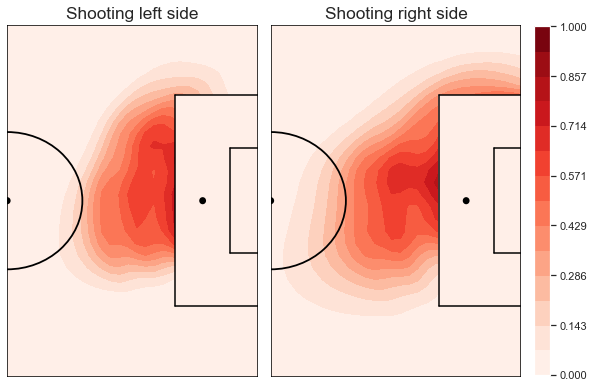

In [27]:
fig, ax = plt.subplots(1,2,figsize=(7.5,5.5))
levels = np.linspace(0,1,15)

a = [0,1]
b = [1,0]
c = ['Shooting left side','Shooting right side']

for i in range(2):

    pitch(ax[i],'black', axis=False, arrow=False)

    X4 = np.full(900, fill_value=a[i])
    X5 = np.full(900, fill_value=b[i])

    XX = np.vstack((X0.flatten(),X1.flatten(),X2.flatten(),X3.flatten(),X4.flatten(),X5.flatten())).T

    Z = gam_2.predict_mu(X=XX)
    Z = Z.reshape(len(X0),len(X1))

    im = ax[i].contourf(X0,X1,Z, cmap='Reds', levels=levels)
    ax[i].contourf(X0_base,X1_base,Z_base, cmap='Reds', levels=levels, zorder=1)

    ax[i].set_xlim(50,100)
    ax[i].set_ylim(0,100)
    
    ax[i].set_title(c[i], fontsize='x-large')
    

norm = mpl.colors.Normalize(vmin=0, vmax=1)
cbar_ax = fig.add_axes([1.0, 0.0375, 0.03, 0.88])
fig.colorbar(im, cax=cbar_ax)
    
plt.tight_layout()
plt.show()

As shown in the plots above, we can see unique patterns for each shot choice (again, for a right-footed free kick taker).

In particular, the left side shots are strong to the far left side of the goal, while they are weaker from the right side. Conversely, right side shots are very strong from the near middle of the field, and strong to the slight left of the center of the pitch.

These results further demonstrate the strength of shooting towards the far post from the left side (i.e. Scenario B from above). Additionally, we show the general strength of shooting from the left side for right-footed kick takers. This may suggest teams should consider involving both a right-footed and left-footed free-kick taker in their squad to take full advantage of all potential free kick opportunities.

### Conclusion and next steps

Our results provide some interesting insights into shot choice for free kicks and suggests a potential under-utilization of "far post" shot attempts, particularly when a shooter is on their strong side (e.g. left side for a right-footed kicker).

My planned next steps for this analysis will be to factor in additional information such as the free kick ability of the kick taker to further strengthen the model. I aim to also use the updated results from this to provide some analysis around the value of having a free kick specialist in a team. This analysis will be based on the prevalence of free kick opportunities and the added scoring probability of a stronger free kick taker.